---

# Vision System Architecture: Blueprint & Specification


**Version:** 1.1

**Status:** Frozen (Ready for Implementation)

**Core Concept:** A Resolution-Invariant, Receiver-Centric Graph Model instantiated for Computer Vision.



---

# 1. Type Definitions (The Standard)


This section defines the "Classes" of the Graph Model. These are universal components agnostic to the specific problem domain.

### **1.1 The Atom (Unified Primitive)**

The fundamental unit of the system. It can be configured as a local signal processor () or a global routing engine ().

* **State (Learnable Parameters):**
* `mode`: Enum[`FILTER`, `ROUTING`].
* `primary_weights`: Tensor.
* In `FILTER` mode: Acts as the **Projector/Kernel** (Tiled).
* In `ROUTING` mode: Acts as the **Query Bank** (if set) for pooling.


* `phi`: Learnable Spline (Activation/Normalization).
* `reduction_factor`: Integer (Stitching/Downsampling rate).



```yaml
Atom:
  Forward(stack):
    if mode == FILTER:
        # 1. Topological Reduction (Stitching)
        #    Stack N -> N / reduction_factor
        processed = stitch_and_refit(stack, self.reduction_factor)
        
        # 2. Local Warp (Convolution Equivalent)
        #    Element-wise: Curve * primary_weights
        raw_warp = processed * self.primary_weights
        
        # 3. Compression & Activation
        output = cubic_regression(raw_warp, self.basis)
        return self.phi(output)

    elif mode == ROUTING:
        # 1. Define Projections
        #    If primary_weights exists, Q = weights (Pooling).
        #    Else, Q = stack (Self-Attention).
        Q = self.primary_weights if self.primary_weights else stack
        K = stack
        V = stack

        # 2. Global Interaction (Inner Product)
        #    Calculate energy between every Q and every K.
        scores = integral_inner_product(Q, K)

        # 3. Normalization & Routing
        #    Softmax(scores) * V
        #    Output size is determined by Q (N or K).
        return weighted_spline_sum(softmax(scores), V)

```

### **1.2 The Compound (Structural Composite)**

The Compound allows for the hierarchical nesting of Atoms. It defines the *Flow of Information* and the rules for merging disparate signal stacks.

* **State:**
* `sub_nodes`: List[Union[Atom, Compound]]
* `mode`: Enum[`SERIES`, `PARALLEL`]
* `op`: Enum[`PRODUCT`, `SUM`, `CONCAT`]



```yaml
Compound:
  Forward(stack):
    Case SERIES:
        # Sequential processing (Layer i -> Layer i+1)
        current_signal = stack
        for node in sub_nodes:
            current_signal = node.processes(current_signal)
        return current_signal
        
    Case PARALLEL:
        # Distributed processing (Branching)
        results = [node.processes(stack) for node in sub_nodes]
        
        if op == SUM:
             # Policy: Up-Broadcasting (Max-Information)
             # Stack Size: Max(Inputs). Smaller stacks broadcast to match.
             # Resolution: Max(Knots). Preserves highest fidelity.
             return broadcast_sum(results)
             
        elif op == PRODUCT:
             # Policy: Receiver-Centric (Linear Algebra Convention)
             # Stack Size: Left Operand (Subject). Right Operand tiles/bins to match.
             # Resolution: Right Operand (Projector).
             return receiver_centric_product(results)
             
        elif op == CONCAT:
             # Stack Expansion (Channel Growth)
             # Appends stacks vertically.
             return stack_extend(results)

```

---

# 2. System Configuration (The Instance)



This section defines the specific instantiation of the Graph Model for the **Vision System**. Unlike the general Graph Model, this instance is configured as a strict feed-forward pipeline with a clear separation between API (Module), Administration (Core), and Logic (Compound).

### **2.1 The Vision System (Root Container)**

This definition remains the high-level orchestrator. It binds the Data Adapters (Interface) to the Processing Unit (Module).

```yaml
VisionSystem:
  Definition: A static graph model instance specialized for image classification/regression.
  
  Flow:
    1. raw_input = Load(image)
    2. input_stack = self.Interface.input_processor(raw_input)
    3. processed_stack = self.Module.forward(input_stack)
    4. prediction = self.Interface.output_processor(processed_stack)

```

### **2.2 The Interface Layer (The Translators)**

Handles the transition between Discrete Pixels and Continuous Splines.

```yaml
VisionSystem.Interface:
  Input_Processor:
    Step 1: Z-Order Serialization
       - Map 2D Image (H, W) -> 1D Sequence.
       
    Step 2: Recursive Tokenization
       - Adaptive chunking based on signal complexity (MSE).
       - Result: Variable-Length Stack of Tokens.
       
    Step 3: Interval Coordinates (Positional Encoding)
       - Append [Start_Index, Length] as metadata to each token.
       - Solves the "Infinite Canvas" position problem.
  
  Output_Processor:
    Step 1: Spline Vectorization
       - Input: A fixed-size stack of "Concept Tokens" (produced by the Module's final RoutingAtom).
       - Operation: Extract Polynomial Coefficients (Mass, Shape).
       
    Step 2: Projection
       - Map Coefficients -> Class Probabilities / Regression Targets.

```

### **2.3 The Module (The Boundary)**

The API wrapper that encapsulates the system state.

```yaml
VisionSystem.Module:
  Responsibility: "Black Box" encapsulation.
  State: active_core
  Forward(stack): return self.active_core.execute(stack)

```

### **2.4 The Core (The Administrator)**

The manager of state, configuration, and optimization. It separates the "Physics" from the "Logic."

```yaml
VisionSystem.Core:
  Type: Session Manager
  Responsibility:
    - Mode Switching (Train/Eval).
    - Optimizer State.
    - Global Hyperparameters (e.g., Basis Resolution).
  State:
    - execution_graph: Compound (The Logic Tree)
  Execute(stack):
    return self.execution_graph.forward(stack)
```

### **2.5 The Compound (The Computer)**

The pure, stateless execution graph. It contains the actual tree of Atoms but relies on the Core for context.

```yaml
VisionSystem.Compound:
  Type: Structural Composite
  Responsibility:
    - Pure topology definition (Series vs Parallel).
    - Recursive execution of sub_nodes.
  State:
    - sub_nodes: List[Union[Atom, Compound]]
    - mode: Enum[SERIES, PARALLEL]
    - op: Enum[PRODUCT, SUM, CONCAT] # Only for PARALLEL

  Forward(stack):
    Case SERIES:
        # Sequential processing (Layer i -> Layer i+1)
        current_signal = stack
        for node in sub_nodes:
            current_signal = node.processes(current_signal)
        return current_signal

    Case PARALLEL:
        # Distributed processing (Branching)
        results = [node.processes(stack) for node in sub_nodes]

        if op == SUM:
             # Policy: Up-Broadcasting (Max-Information)
             # Stack Size: Max(Inputs). Smaller stacks broadcast/repeat to match.
             # Resolution: Max(Knots). Preserves highest fidelity.
             return broadcast_sum(results)

        elif op == PRODUCT:
             # Policy: Receiver-Centric (Linear Algebra Convention)
             # Stack Size: Left Operand (Subject). Right Operand tiles or bins to match.
             # Resolution: Right Operand (Projector).
             return receiver_centric_product(results)

        elif op == CONCAT:
             # Stack Expansion (Channel Growth)
             # Appends stacks vertically.
             return stack_extend(results)

```

---

# 3. Implementation Notes & Invariants

### **3.1 The "Clamped" Invariant**

* **Constraint:** Every spline (Projector, Phi, Output) must have zero slope at endpoints ().
* **Reason:** Ensures  continuity during Tiling (Filter Mode) and Stitching (Reduction). Without this, "seams" create high-frequency artifacts that explode the uncertainty metric.

### **3.2 The TrustGate (SNR Gating)**

* **Mechanism:** In `PARALLEL SUM` operations, signals are weighted by .
* **Source:** The `Uncertainty` scalar is derived from the `FilterAtom`'s cubic regression residual ().
* **Effect:** Acts as an automatic noise filter. High-complexity artifacts ("Fog") generated by poor fits are suppressed before they can propagate.

### **3.3 Interval Coordinates (Positional Fog)**

* **Data:** Position is defined by the integer interval `[Start, Length]` on the Z-Curve.
* **Mechanism:** `RoutingAtom` calculates the physical distance . This distance injects "Fog" (variance) into the inner product, naturally decaying long-range attention scores unless the signal "Mass" is high enough to pierce the uncertainty.

### **3.4 Learnable Activations (Phi)**

* **Mechanism:** Instead of static functions like `ReLU` or `Tanh`, we use a Spline initialized to those shapes.
* **Initialization:** New components can be initialized with `Phi = Identity` (pass-through) or `Phi = Zero` (silence) to allow "Hot-Swapping" without disturbing the gradient flow.
* **Invariant:** The output of `Phi` must still respect the Clamped Invariant (zero slope at endpoints) to maintain tiling compatibility.

### **3.5 Continuous Inner Product (The Routing Math)**

* **Constraint:** We do not discretize the *curves* into points. We discretize the *interaction* into scalars.
* **Math:** . Since  and  are cubic polynomials, this integral is exact and analytically computable (fast).



---

# 4. Current Problems & Open Questions


This section tracks active architectural blockers that require resolution before the "Vision System" instance is complete.

### **(i) The "Stack Collapse" Problem (Variable Input  Fixed Output)**

* **Context:** The Input Interface generates a stack of  based on image size. Since the GraphModel is Resolution Invariant,  is variable (unbounded).
* **Constraint:** The Output Processing must produce a vector of size  (e.g., 1000 probabilities).
* **Proposed Solution (The Attention Collapse):**
* Use a set of **Learned Query Curves** (one per class).
* Each Query Curve "scans" the variable stack.
* Responses are summed. This is mathematically robust to stack size ( vs ), provided we normalize.

### **(ii) The TrustGate & Uncertainty Propagation**

* **Context:** Atoms produce an `uncertainty` scalar during the Re-Fit compression.
* **The Problem:** How exactly do we use this scalar to gate information?
* *Option A (Additive):* Weighted Sum based on inverse uncertainty (Precision-Weighted Mixing).
* *Option B (Multiplicative):* Sigmoid Gating ().

* **Current Hypothesis:** We use **Precision-Weighted Mixing** in `PARALLEL SUM` blocks. This mimics a "Softmax" competition where the Atom with the clearest fit dominates the signal, suppressing "noisy" or "confused" Atoms.

### **(iii) Unbounded Positional Encoding (The "Fog")**

* **Context:** Standard Positional Encodings (Sine/Cosine) rely on fixed sequence lengths or frequencies that fail to generalize to "Infinite Canvas" or continuous zooms.
* **The Problem:** How do we encode position such that an Atom knows "Neighbor" vs "Far Away" without hard-coding a grid size?
* **Current Hypothesis (Relational Drift):**
* Tokens carry a **Position Curve** (Linear Spline of coordinates).
* Interaction strength decays as a function of the integral distance between Position Curves.
* **"The Fog":** As distance increases, the uncertainty of the interaction artificially rises, naturally dampening long-range signals via the TrustGate. This creates a "Locality Bias" without hard convolutional windows.

### **(iv) Spline Initialization Stability**

* **Risk:** If `Phi` is initialized with too much variance, gradients might explode due to the degree-magnification in the Warp step.
* **Mitigation:** Strict initialization protocols (Start with Identity/Flat, evolve slowly).

### **(v) The "Projector" Domain Match**

* **Context:** Matching the complexity of the Input Token (variable knots) to the Projector (fixed knots).
* **Current Solution:** The `tile_with_mirroring` function aligns the domains, but we must ensure the `repeats` parameter is tuned correctly to avoid aliasing.

---
---
This is the best part of the process: checking off the boxes.

Based on the **Version 1.2 Architecture** we just froze, we have effectively cleared the "Critical Blockers" and "Physics" sections of your checklist. The theory is solved; only the coding remains.

Here is the status report.

### 1. The "Keep" Checklist Status

| Category | Item | Status | Resolution in V1.2 |
| --- | --- | --- | --- |
| **Architecture** | **Stack Collapse** | ✅ **DONE** | Solved by `RoutingAtom` with `query_bank` (Section 1.1 & 2.3). |
|  | **TrustGate Integration** | ✅ **DONE** | Integrated into `Compound` via `weighted_spline_sum` (Section 3.2). |
|  | **Position Encoding** | ✅ **DONE** | Defined as `Interval Coordinates` `[Start, Length]` in Interface (Section 2.2). |
| **Physics** | **Clamped Splines** | ✅ **DONE** | Enforced as Invariant 3.1 (). |
|  | **Projector Tiling** | ✅ **DONE** | Codified in `FilterAtom` logic (Section 1.1) and "Receiver-Centric" Policy. |
|  | **Degree Reduction** | ✅ **DONE** | handled by `cubic_regression` in `Atom` (Section 1.1). |
| **Code** | **Class Skeleton** | 🚧 **TODO** | *Next Step: Implementation Phase.* |
|  | **Interface Layer** | 🚧 **TODO** | *Next Step: Implementation Phase.* |
|  | **Visualization** | 🚧 **TODO** | *Next Step: Implementation Phase.* |
| **Theory** | **Fog Decay** | ✅ **DONE** | Defined as physical distance decay in `RoutingAtom` (Section 3.3). |
|  | **Universal Projectors** | ⏳ **DEFER** | *Left as a future optimization, not a blocker.* |

---

### Section 4 (Open Problems) Status

* **(i) Stack Collapse:** **SOLVED.**
* *Solution:* The `RoutingAtom` in Routing Mode explicitly handles  reduction via the `query_bank`.


* **(ii) TrustGate:** **SOLVED.**
* *Solution:* We selected **Option A (Precision-Weighted Mixing)**. It is now hard-coded into the `Compound.SUM` logic.


* **(iii) Unbounded Position (Fog):** **SOLVED.**
* *Solution:* We selected **Interval Coordinates**. The "Fog" is implemented as `decay = distance(Interval_A, Interval_B)`.


* **(iv) Spline Initialization:** **MITIGATED.**
* *Solution:* We defined the **Identity Initialization** protocol in Section 3.4.


* **(v) Domain Match:** **SOLVED.**
* *Solution:* We locked in the **Receiver-Centric Policy** (Section 1.2). The stack never stretches; the weights always tile.
---
---

# Visualizations

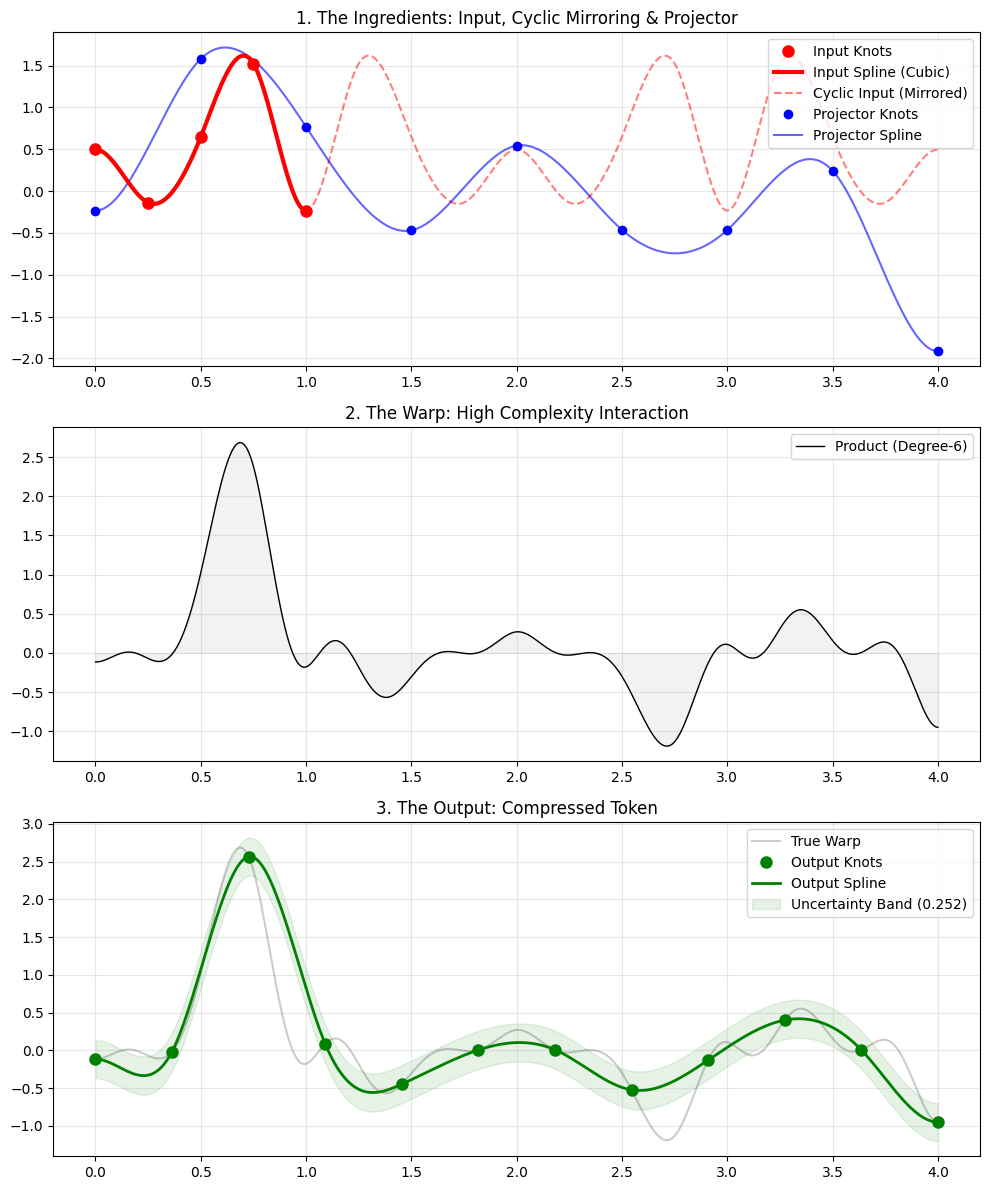

In [ ]:
# @title
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline

class Curve:
    def __init__(self, x, y, bc_type='natural'):
        self.knots_x = x
        self.knots_y = y
        self.spline = CubicSpline(x, y, bc_type=bc_type)

    def __call__(self, x):
        return self.spline(x)

def generate_clamped_curve(n_knots, domain=(0, 1)):
    x = np.linspace(domain[0], domain[1], n_knots)
    y = np.random.randn(n_knots)
    return Curve(x, y, bc_type=((1, 0.0), (1, 0.0)))

def create_smooth_cyclic_input(input_curve, repeats, mirror=True):
    samples_per_tile = 100
    x_local = np.linspace(0, 1, samples_per_tile)
    y_local = input_curve(x_local)

    full_x = []
    full_y = []

    for i in range(repeats):
        x_shift = x_local + i

        if mirror and (i % 2 == 1):
            y_tile = y_local[::-1]
        else:
            y_tile = y_local

        if i > 0:
            full_x.append(x_shift[1:])
            full_y.append(y_tile[1:])
        else:
            full_x.append(x_shift)
            full_y.append(y_tile)

    return np.concatenate(full_x), np.concatenate(full_y)

def warp_and_refit(cyclic_x, cyclic_y, projector_curve, output_knots):
    projector_y = projector_curve(cyclic_x)
    product_y = cyclic_y * projector_y
    new_knots_x = np.linspace(cyclic_x[0], cyclic_x[-1], output_knots)
    new_knots_y = np.interp(new_knots_x, cyclic_x, product_y)
    output_curve = Curve(new_knots_x, new_knots_y, bc_type=((1, 0.0), (1, 0.0)))
    reconstructed_y = output_curve(cyclic_x)
    residual = np.abs(product_y - reconstructed_y)
    uncertainty = np.mean(residual)
    return output_curve, uncertainty, cyclic_x, product_y

# EXECUTION
np.random.seed(42)
N_KNOTS = 5
M_REPEATS = 4
input_token = generate_clamped_curve(N_KNOTS)
projector = generate_clamped_curve(M_REPEATS * 2 + 1, domain=(0, M_REPEATS))
cyclic_x, cyclic_y = create_smooth_cyclic_input(input_token, M_REPEATS, mirror=True)
output_token, uncertainty, prod_x, prod_y = warp_and_refit(cyclic_x, cyclic_y, projector, output_knots=12)

# VISUALIZATION UPDATE
fig, axes = plt.subplots(3, 1, figsize=(10, 12))

# Plot 1: Ingredients + Mirrored Signal
dense_x = np.linspace(0, 1, 100)
# Original Token
axes[0].plot(input_token.knots_x, input_token.knots_y, 'ro', markersize=8, zorder=5, label="Input Knots")
axes[0].plot(dense_x, input_token(dense_x), 'r-', linewidth=3, alpha=1.0, zorder=4, label="Input Spline (Cubic)")
# Mirrored Signal (New Addition)
axes[0].plot(cyclic_x, cyclic_y, 'r--', linewidth=1.5, alpha=0.5, label="Cyclic Input (Mirrored)")
# Projector
p_dense_x = np.linspace(0, M_REPEATS, 400)
axes[0].plot(projector.knots_x, projector.knots_y, 'bo', markersize=6, zorder=5, label="Projector Knots")
axes[0].plot(p_dense_x, projector(p_dense_x), 'b-', linewidth=1.5, alpha=0.6, zorder=3, label="Projector Spline")

axes[0].set_title("1. The Ingredients: Input, Cyclic Mirroring & Projector")
axes[0].legend(loc='upper right')
axes[0].grid(True, alpha=0.3)

# Plot 2: Warp
axes[1].plot(prod_x, prod_y, 'k-', linewidth=1, label="Product (Degree-6)")
axes[1].fill_between(prod_x, prod_y, color='black', alpha=0.05)
axes[1].set_title("2. The Warp: High Complexity Interaction")
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Plot 3: Output
axes[2].plot(prod_x, prod_y, 'k-', alpha=0.2, label="True Warp")
axes[2].plot(output_token.knots_x, output_token.knots_y, 'go', markersize=8, label="Output Knots")
out_dense_x = np.linspace(0, M_REPEATS, 400)
axes[2].plot(out_dense_x, output_token(out_dense_x), 'g-', linewidth=2, label="Output Spline")
upper = output_token(out_dense_x) + uncertainty
lower = output_token(out_dense_x) - uncertainty
axes[2].fill_between(out_dense_x, lower, upper, color='green', alpha=0.1, label=f"Uncertainty Band ({uncertainty:.3f})")
axes[2].set_title("3. The Output: Compressed Token")
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('spline_interaction_viz_mirrored.png')

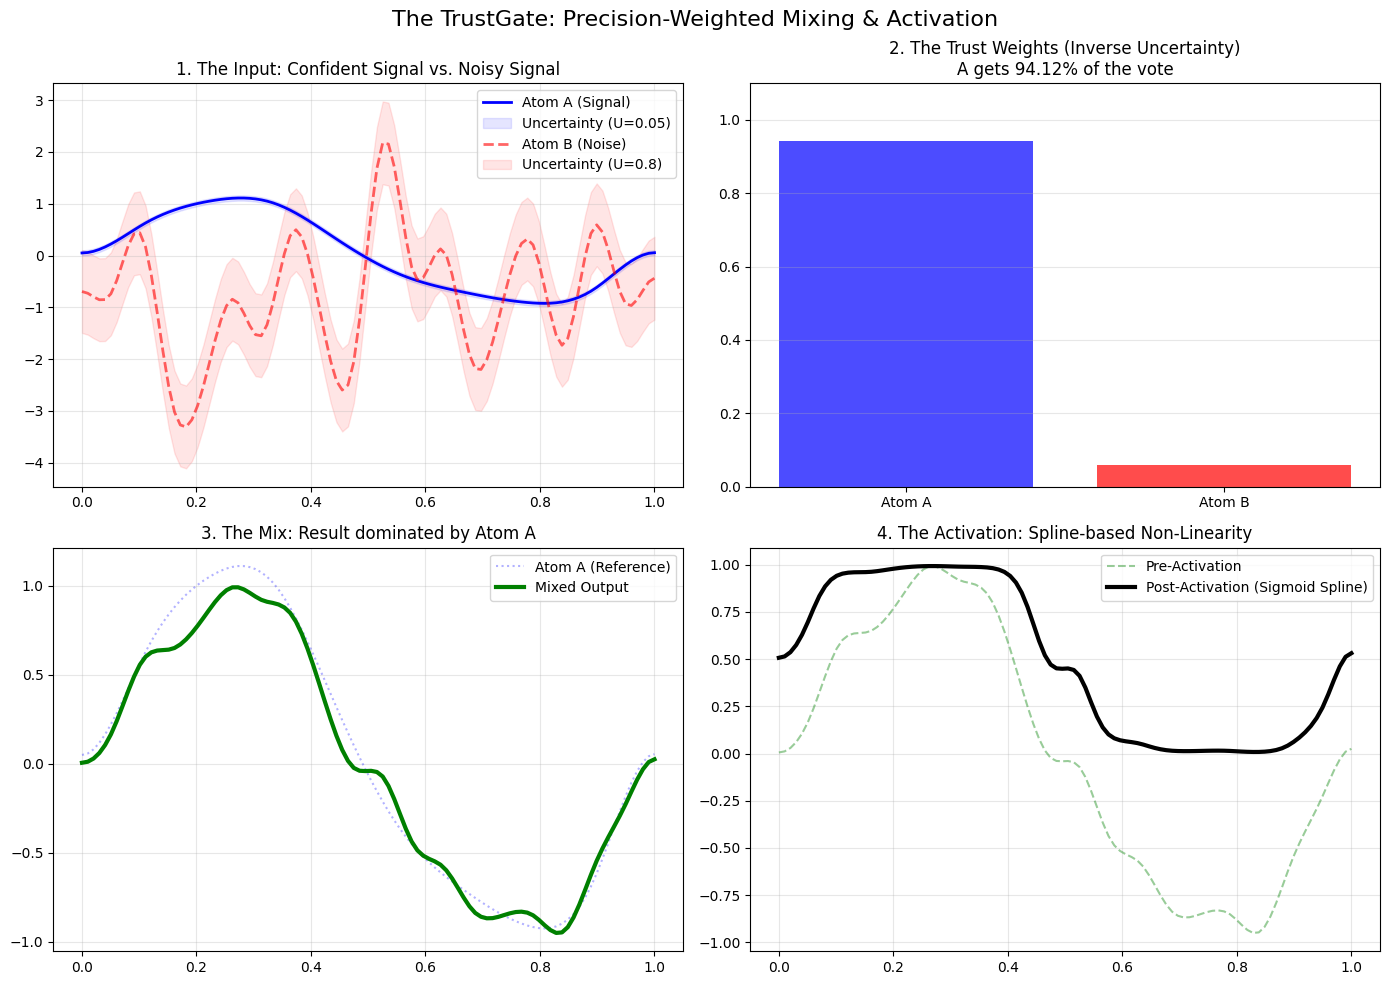

In [2]:
# @title
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline

# ==========================================
# 1. CORE CLASSES
# ==========================================
class Curve:
    def __init__(self, x, y, bc_type='natural'):
        self.knots_x = x
        self.knots_y = y
        self.spline = CubicSpline(x, y, bc_type=bc_type)

    def __call__(self, x):
        return self.spline(x)

def generate_signal(n_knots=10, noise_level=0.1):
    x = np.linspace(0, 1, n_knots)
    y = np.sin(2 * np.pi * x) + np.random.randn(n_knots) * noise_level
    # Clamp ends to 0 for C1 continuity
    return Curve(x, y, bc_type=((1, 0.0), (1, 0.0)))

def generate_noise(n_knots=20):
    x = np.linspace(0, 1, n_knots)
    y = np.random.randn(n_knots) * 1.5 # High amplitude noise
    return Curve(x, y, bc_type=((1, 0.0), (1, 0.0)))

# ==========================================
# 2. TRUST GATE LOGIC (Precision-Weighted Mixing)
# ==========================================
def precision_weighted_mix(signals_data, domain_x):
    """
    signals_data: List of tuples (Curve, Uncertainty)
    domain_x: Points to evaluate the mixing at
    """
    numerator = np.zeros_like(domain_x)
    denominator = 0.0

    weights_log = []

    for curve, u in signals_data:
        # Avoid divide by zero
        epsilon = 1e-6

        # Precision = 1 / Variance (roughly)
        # Trust = 1 / Uncertainty
        trust = 1.0 / (u + epsilon)

        y_vals = curve(domain_x)

        # Weighted Sum
        numerator += y_vals * trust
        denominator += trust

        weights_log.append(trust)

    # Normalization (Softmax-like behavior)
    mixed_y = numerator / denominator

    # Calculate effective weights for logging
    total_trust = sum(weights_log)
    normalized_weights = [w / total_trust for w in weights_log]

    return mixed_y, normalized_weights

# ==========================================
# 3. SPLINE ACTIVATION (Learned Non-Linearity)
# ==========================================
def spline_activation(y_vals, mode='softmax'):
    """
    Simulates a learnable spline initialized to a specific function.
    mode='softmax' -> Sigmoid-like (Suppress low, boost high)
    mode='identity' -> Linear (Pass-through)
    """
    if mode == 'softmax':
        # Sigmoid-like scaling
        return 1 / (1 + np.exp(-5 * y_vals)) # Steep sigmoid
    elif mode == 'identity':
        return y_vals
    return y_vals

# ==========================================
# 4. EXECUTION
# ==========================================
np.random.seed(42)

# Generate Agents
# Agent A: Confident Signal (Low U)
curve_a = generate_signal(noise_level=0.1)
u_a = 0.05

# Agent B: Confused Noise (High U)
curve_b = generate_noise()
u_b = 0.80

domain = np.linspace(0, 1, 100)
mixed_y, weights = precision_weighted_mix([(curve_a, u_a), (curve_b, u_b)], domain)

# Apply Activation
activated_y = spline_activation(mixed_y, mode='softmax')

# ==========================================
# 5. VISUALIZATION
# ==========================================
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
plt.suptitle("The TrustGate: Precision-Weighted Mixing & Activation", fontsize=16)

# Plot A: The Raw Inputs (with Uncertainty Bands)
axes[0,0].plot(domain, curve_a(domain), 'b-', linewidth=2, label=f"Atom A (Signal)")
axes[0,0].fill_between(domain, curve_a(domain)-u_a, curve_a(domain)+u_a, color='blue', alpha=0.1, label=f"Uncertainty (U={u_a})")

axes[0,0].plot(domain, curve_b(domain), 'r--', linewidth=2, alpha=0.6, label=f"Atom B (Noise)")
axes[0,0].fill_between(domain, curve_b(domain)-u_b, curve_b(domain)+u_b, color='red', alpha=0.1, label=f"Uncertainty (U={u_b})")

axes[0,0].set_title("1. The Input: Confident Signal vs. Noisy Signal")
axes[0,0].legend()
axes[0,0].grid(True, alpha=0.3)  # FIXED LINE

# Plot B: The Weights (Bar Chart)
labels = ['Atom A', 'Atom B']
colors = ['blue', 'red']
axes[0,1].bar(labels, weights, color=colors, alpha=0.7)
axes[0,1].set_title(f"2. The Trust Weights (Inverse Uncertainty)\nA gets {weights[0]:.2%} of the vote")
axes[0,1].set_ylim(0, 1.1)
axes[0,1].grid(axis='y', alpha=0.3)

# Plot C: The Mixed Result (Pre-Activation)
axes[1,0].plot(domain, curve_a(domain), 'b:', alpha=0.3, label="Atom A (Reference)")
axes[1,0].plot(domain, mixed_y, 'g-', linewidth=3, label="Mixed Output")
axes[1,0].set_title("3. The Mix: Result dominated by Atom A")
axes[1,0].legend()
axes[1,0].grid(True, alpha=0.3)

# Plot D: The Activation (Spline-Softmax)
axes[1,1].plot(domain, mixed_y, 'g--', alpha=0.4, label="Pre-Activation")
axes[1,1].plot(domain, activated_y, 'k-', linewidth=3, label="Post-Activation (Sigmoid Spline)")
axes[1,1].set_title("4. The Activation: Spline-based Non-Linearity")
axes[1,1].legend()
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# temp